[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/S07singh/DeepAQI-Delhi-Air-Quality-Forecasting-using-GRU-and-LSTM/blob/main/Smart_Motorcycle_Traffic_Violation_Detection_System.ipynb)

# Delhi Air Pollution: Deep Learning Time-Series Forecasting (Full Data)

GRU and LSTM models for AQI forecasting using the **complete 14-station dataset**
(2.9M rows aggregated to ~208k hourly city-wide averages).

**Sections:**
1. Data Loading & Aggregation
2. Exploratory Data Analysis
3. Feature Engineering
4. Train / Val / Test Split
5. Scaling
6. Sequence Creation
7. GRU Model
8. LSTM Model
9. Evaluation & Comparison
10. Save & Download

## 0. Environment Setup

In [1]:
import os, time, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, initializers, regularizers
import joblib

warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

print('TensorFlow version:', tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print('GPUs available:', gpus)
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
sns.set_style('whitegrid')

TensorFlow version: 2.19.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Data Loading

In [2]:
from google.colab import files
uploaded = files.upload()

Saving delhi_pollution_hourly.parquet to delhi_pollution_hourly.parquet


In [3]:
df_raw = pd.read_parquet('delhi_pollution_hourly.parquet')
df_raw['event_timestamp'] = pd.to_datetime(df_raw['event_timestamp'])
print('Raw dataset shape:', df_raw.shape)
print('Date range:', df_raw['event_timestamp'].min(), 'to', df_raw['event_timestamp'].max())
print('Unique stations:', df_raw['city'].nunique() if 'city' in df_raw.columns else 'N/A')
print('\nStations:')
if 'city' in df_raw.columns:
    print(df_raw['city'].value_counts())
df_raw.head()

Raw dataset shape: (2921413, 15)
Date range: 2000-03-15 13:44:28.651396 to 2024-11-05 13:44:28.651396
Unique stations: 14

Stations:
city
Wazirpur                              215514
Jhilmil                               215514
Jawaharlal Nehru Stadium              215514
Siri Fort                             215514
Major Dhyan Chand National Stadium    215514
R.K. Puram                            215514
Jahangirpuri                          215514
Anand Vihar                           212135
Mandir Marg                           212111
Pusa                                  212022
Sonia Vihar                           207239
Sriniwaspuri                          206920
Parparganj                            203822
Delhi                                 158566
Name: count, dtype: int64


,location_id,city,event_timestamp,temperature,humidity,pressure,wind_speed,wind_direction,pm25,pm10,no2,so2,o3,co,aqi
0,"Delhi Institute of Tool Engineering, Wazirpur,...",Wazirpur,2000-03-15 13:44:28.651396,30.450,74.100,990.425,0.300,21.7,252.0,332.0,62.4,4.8,22.4,35.7,332.0
1,"Satyawati College, Delhi, Delhi, India",Delhi,2000-03-15 13:44:28.651396,26.675,74.350,980.650,1.375,55.3,256.0,234.0,59.2,11.9,2.1,33.8,256.0
2,"ITI Shahdra, Jhilmil Industrial Area, Delhi, D...",Jhilmil,2000-03-15 13:44:28.651396,28.775,62.925,984.350,0.300,221.3,265.0,210.0,48.3,5.1,8.2,35.1,265.0
3,"Sonia Vihar Water Treatment Plant DJB, Delhi, ...",Sonia Vihar,2000-03-15 13:44:28.651396,26.575,78.525,991.300,0.300,313.6,251.0,177.0,16.5,1.8,1.7,24.9,251.0
4,"PGDAV College, Sriniwaspuri, Delhi, Delhi, India",Sriniwaspuri,2000-03-15 13:44:28.651396,22.300,71.425,985.650,0.300,347.1,282.0,347.0,43.1,5.2,3.4,29.9,347.0


### 1.1 Aggregate Across All 14 Stations

Average all stations per hourly timestamp → single city-wide time series.
This prevents lag features from crossing station boundaries.

In [4]:
drop_cols = [c for c in ['location_id', 'city'] if c in df_raw.columns]
df_agg = df_raw.drop(columns=drop_cols)

df_agg['event_timestamp'] = df_agg['event_timestamp'].dt.floor('h')
df = df_agg.groupby('event_timestamp').mean().reset_index()
df = df.sort_values('event_timestamp').reset_index(drop=True)

print('After aggregation:', df.shape)
print('Date range:', df['event_timestamp'].min(), 'to', df['event_timestamp'].max())
df.head()

After aggregation: (215514, 13)
Date range: 2000-03-15 13:00:00 to 2024-11-05 13:00:00


,event_timestamp,temperature,humidity,pressure,wind_speed,wind_direction,pm25,pm10,no2,so2,o3,co,aqi
0,2000-03-15 13:00:00,27.207714,71.288429,984.611571,0.480786,205.0,246.714286,296.714286,46.864286,5.864286,7.5,23.307143,316.785714
1,2000-03-15 14:00:00,27.207714,71.288429,984.611571,0.480786,205.0,246.714286,296.714286,46.864286,5.864286,7.5,23.307143,316.785714
2,2000-03-15 15:00:00,27.207714,71.288429,984.611571,0.480786,205.0,246.714286,296.714286,46.864286,5.864286,7.5,23.307143,316.785714
3,2000-03-15 16:00:00,27.207714,71.288429,984.611571,0.480786,205.0,246.714286,296.714286,46.864286,5.864286,7.5,23.307143,316.785714
4,2000-03-15 17:00:00,27.207714,71.288429,984.611571,0.480786,205.0,246.714286,296.714286,46.864286,5.864286,7.5,23.307143,316.785714


## 2. Exploratory Data Analysis

### 2.1 Dataset Overview

In [5]:
print('Shape:', df.shape)
print('\nColumn data types:')
print(df.dtypes)
print('\nBasic statistics:')
df.describe()

Shape: (215514, 13)

Column data types:
event_timestamp    datetime64[ns]
temperature               float64
humidity                  float64
pressure                  float64
wind_speed                float64
wind_direction            float64
pm25                      float64
pm10                      float64
no2                       float64
so2                       float64
o3                        float64
co                        float64
aqi                       float64
dtype: object

Basic statistics:


,event_timestamp,temperature,humidity,pressure,wind_speed,wind_direction,pm25,pm10,no2,so2,o3,co,aqi
count,215514,215514.000000,215514.000000,215514.000000,215514.000000,215514.000000,215514.000000,215514.000000,215514.000000,215514.000000,215514.000000,215514.000000,215514.000000
mean,2012-07-17 17:23:41.030652160,29.665880,59.743205,983.942505,0.572089,166.266990,243.146298,253.311759,27.524240,6.982470,28.493624,18.804423,285.202697
min,2000-03-15 13:00:00,25.100286,44.834643,981.919214,0.365357,108.862556,189.384615,158.538462,15.035714,5.864286,7.000000,9.964286,196.538462
25%,2006-05-29 18:15:00,27.031923,46.674357,982.848071,0.433308,150.561571,198.142857,180.000000,19.814286,6.314286,9.284615,11.864286,220.923077
50%,2012-07-21 16:30:00,30.854154,52.287538,983.776385,0.496143,167.584643,235.928571,218.571429,27.292857,6.669231,25.042857,13.657143,250.857143
75%,2018-09-13 14:45:00,32.378214,73.003308,985.103857,0.696143,178.946143,287.071429,356.357143,36.253846,7.630769,43.471429,23.407143,384.285714
max,2024-11-05 13:00:00,32.796143,84.116571,986.334857,0.911571,208.969214,351.250000,436.400000,47.100000,8.907143,52.707692,39.957143,444.200000
std,NaN,2.777808,14.081552,1.358472,0.161660,18.605859,46.961155,82.763986,9.185047,0.894365,16.662182,9.434664,78.435208


### 2.2 Missing Value Analysis

In [6]:
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
missing_df = missing_df[missing_df['Count'] > 0].sort_values('Percentage', ascending=False)

if len(missing_df) > 0:
    print('Columns with missing values:')
    print(missing_df)
    fig, ax = plt.subplots(figsize=(12, 5))
    missing_df['Percentage'].plot(kind='bar', color='coral', ax=ax)
    ax.set_title('Missing Value Percentage by Column')
    ax.set_ylabel('Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(); plt.show()
else:
    print('No missing values detected.')

No missing values detected.


### 2.3 Identify Numerical Columns and Target

In [7]:
TARGET = 'aqi'
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in num_cols if c != TARGET]
print('Target:', TARGET)
print('Features:', feature_cols)
print('Count:', len(feature_cols))

Target: aqi
Features: ['temperature', 'humidity', 'pressure', 'wind_speed', 'wind_direction', 'pm25', 'pm10', 'no2', 'so2', 'o3', 'co']
Count: 11


### 2.4 Distribution Plots

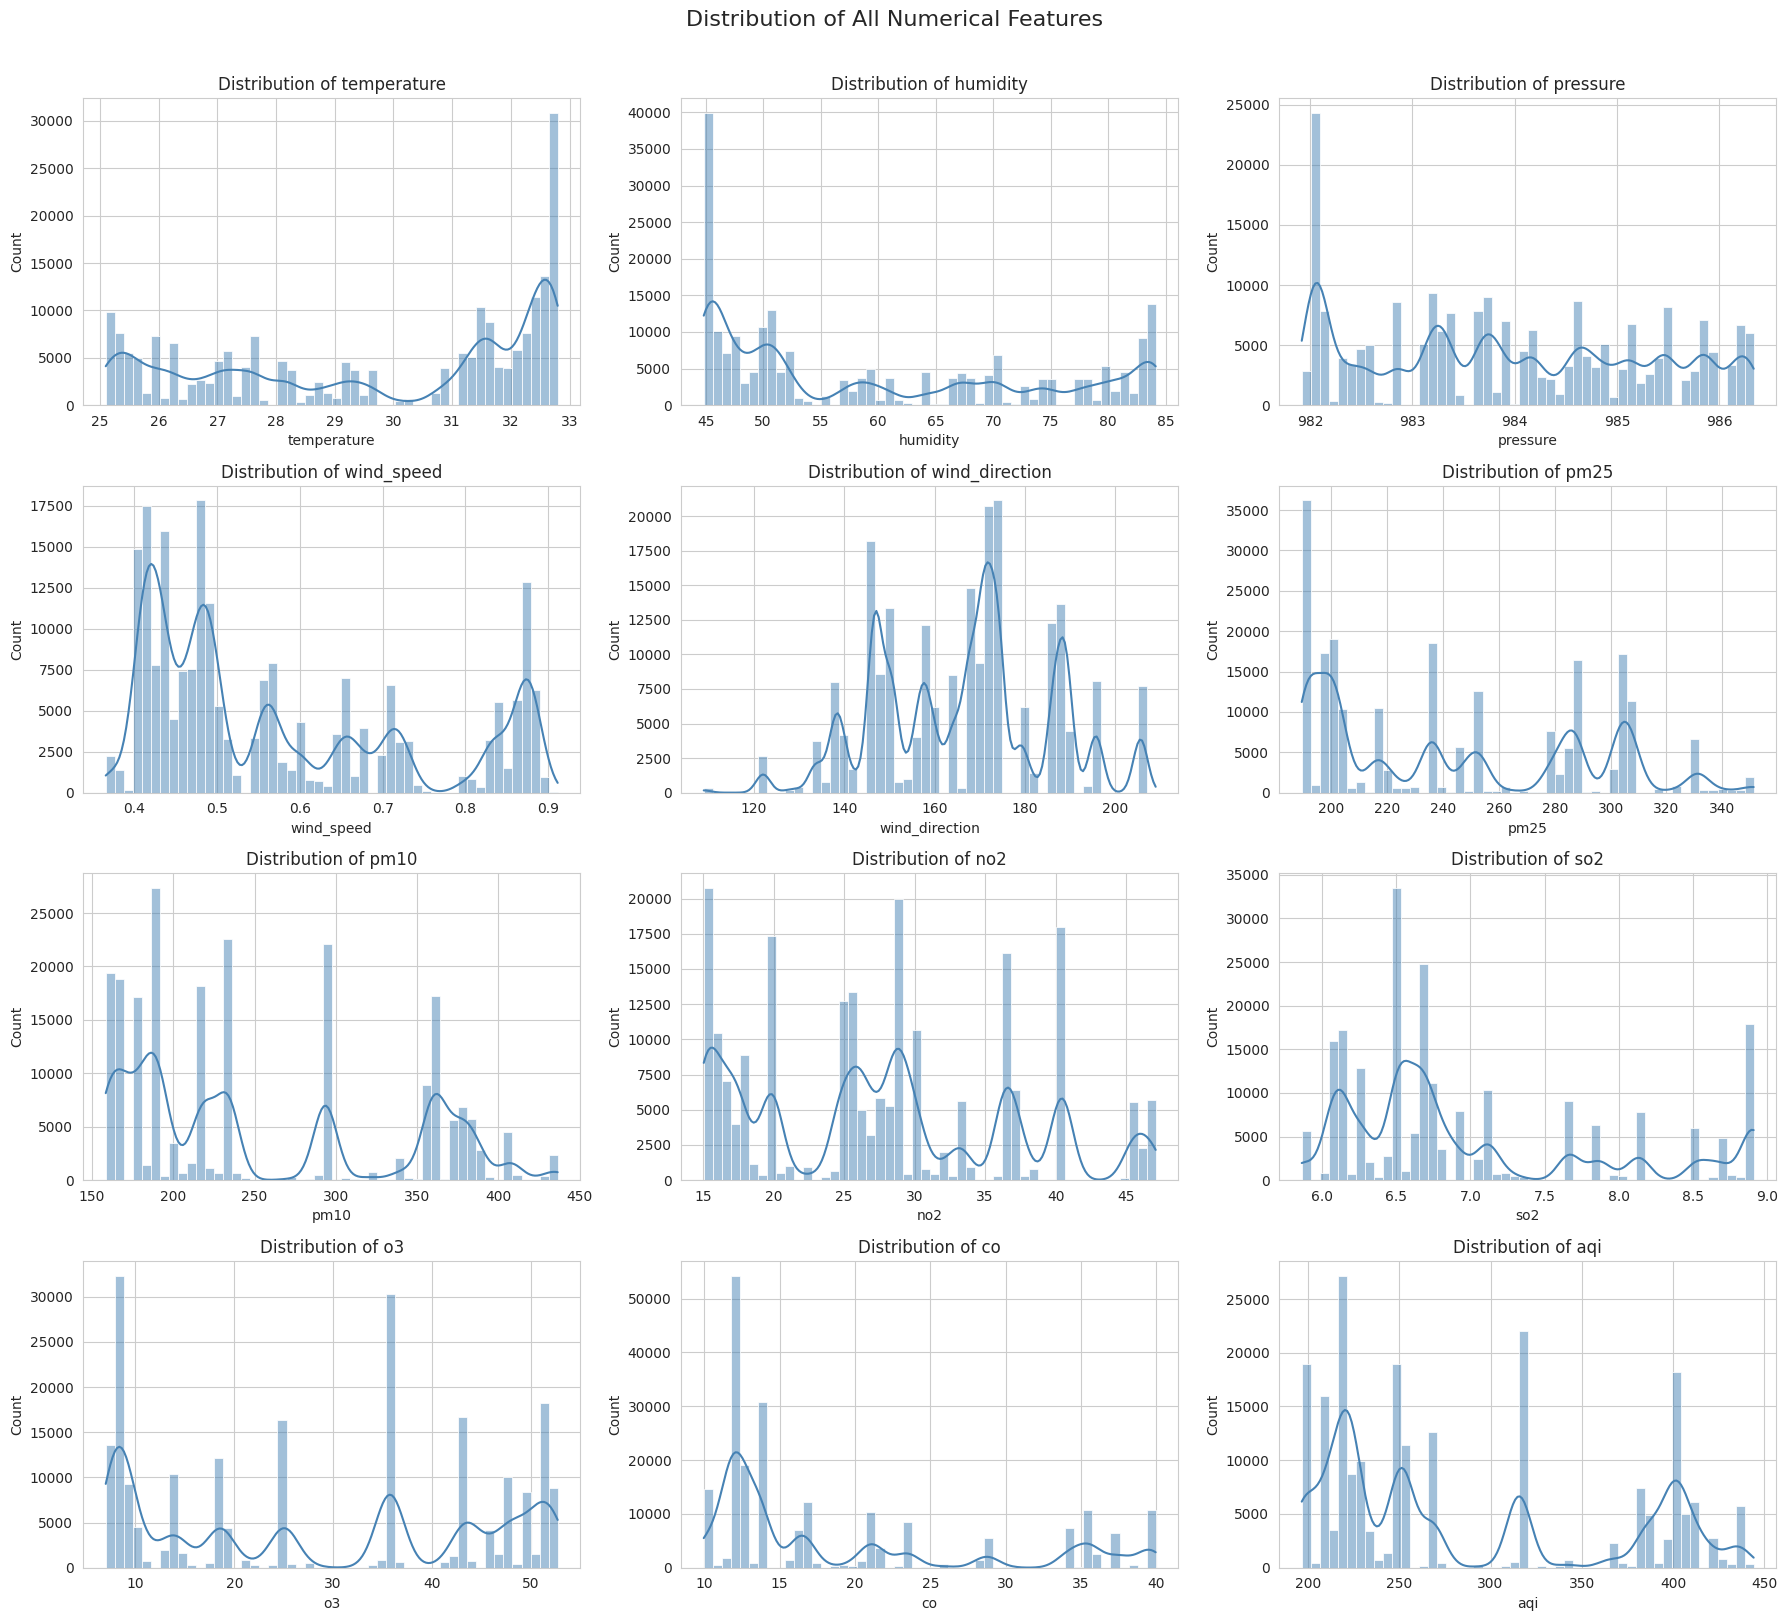

In [8]:
n = len(num_cols); ncols = 3; nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i], color='steelblue', bins=50)
    axes[i].set_title(f'Distribution of {col}')
for j in range(i + 1, len(axes)): axes[j].set_visible(False)
plt.suptitle('Distribution of All Numerical Features', y=1.01, fontsize=16)
plt.tight_layout(); plt.show()

### 2.5 Correlation Heatmap

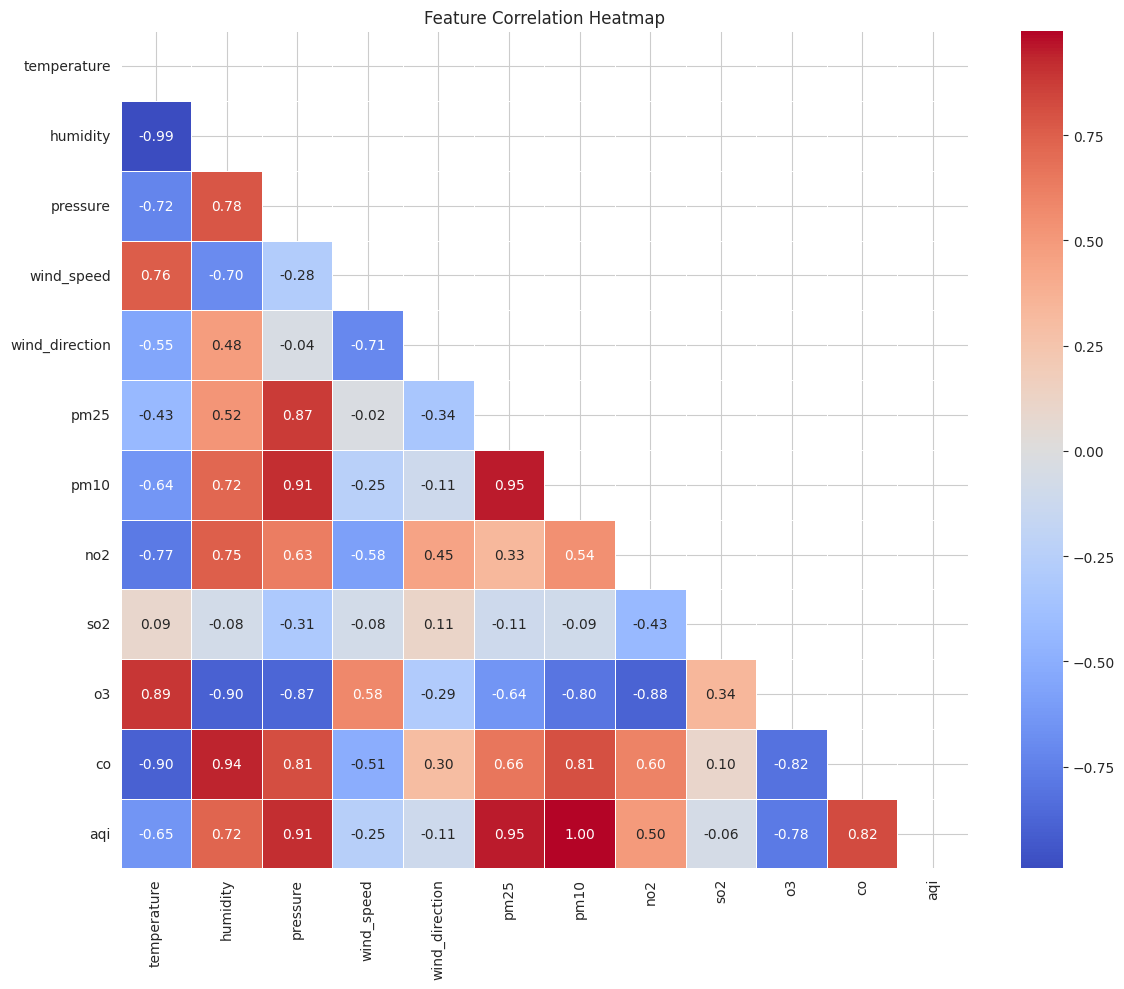

In [9]:
corr = df[num_cols].corr()
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5, ax=ax)
ax.set_title('Feature Correlation Heatmap')
plt.tight_layout(); plt.show()

### 2.6 AQI Time Series

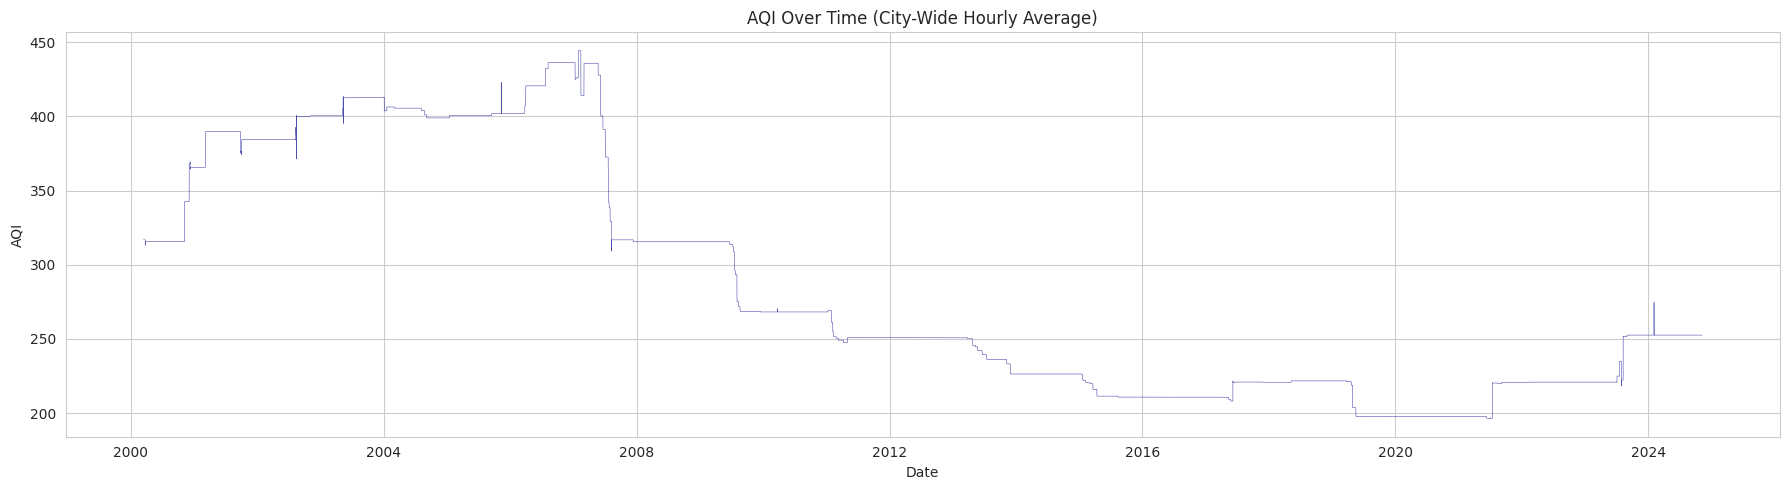

In [10]:
fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(df['event_timestamp'], df[TARGET], linewidth=0.4, color='darkblue', alpha=0.7)
ax.set_title('AQI Over Time (City-Wide Hourly Average)')
ax.set_xlabel('Date'); ax.set_ylabel('AQI')
plt.tight_layout(); plt.show()

### 2.7 Seasonal Decomposition

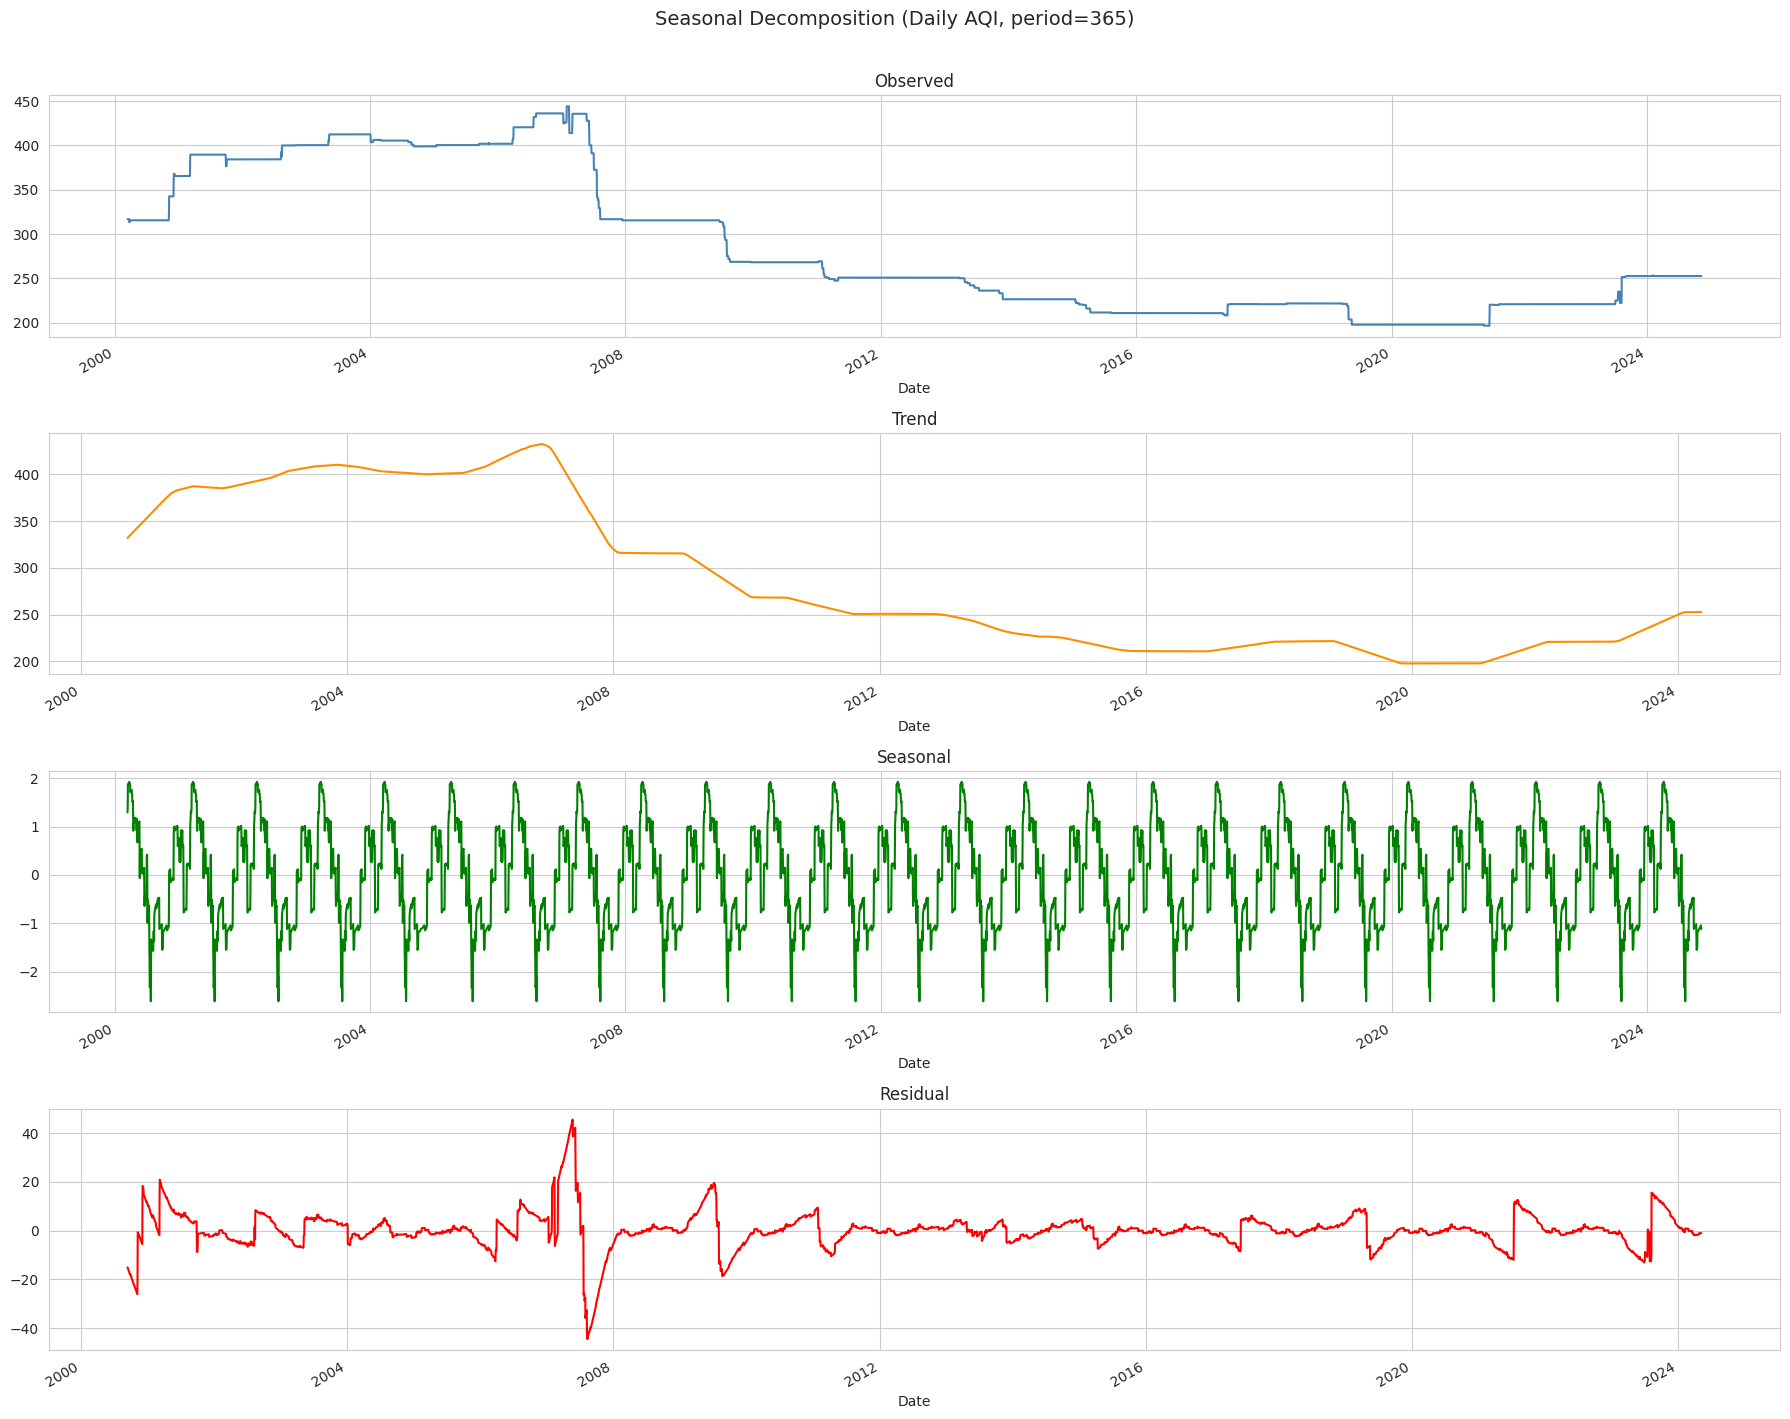

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
daily_aqi = df.set_index('event_timestamp')[TARGET].resample('D').mean().dropna()
decomp = seasonal_decompose(daily_aqi, model='additive', period=365)
fig, axes = plt.subplots(4, 1, figsize=(18, 14))
decomp.observed.plot(ax=axes[0], title='Observed', color='steelblue')
decomp.trend.plot(ax=axes[1], title='Trend', color='darkorange')
decomp.seasonal.plot(ax=axes[2], title='Seasonal', color='green')
decomp.resid.plot(ax=axes[3], title='Residual', color='red')
for ax in axes: ax.set_xlabel('Date')
plt.suptitle('Seasonal Decomposition (Daily AQI, period=365)', y=1.01, fontsize=14)
plt.tight_layout(); plt.show()

### 2.8 Feature Importance

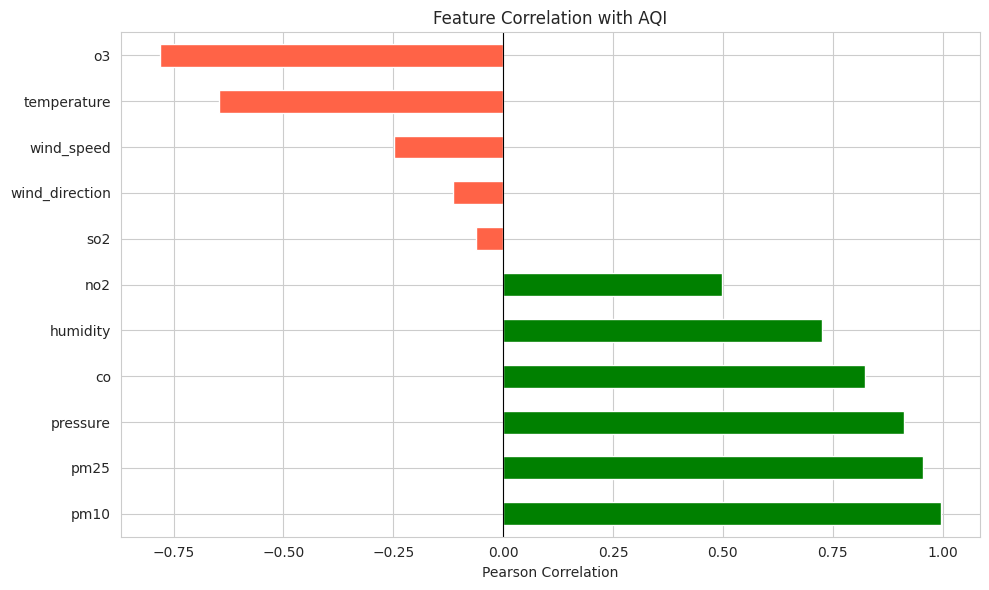

In [12]:
aqi_corr = df[num_cols].corr()[TARGET].drop(TARGET).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if v > 0 else 'tomato' for v in aqi_corr.values]
aqi_corr.plot(kind='barh', color=colors, ax=ax)
ax.set_title('Feature Correlation with AQI')
ax.set_xlabel('Pearson Correlation')
ax.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout(); plt.show()

### 2.9 Rolling Statistics

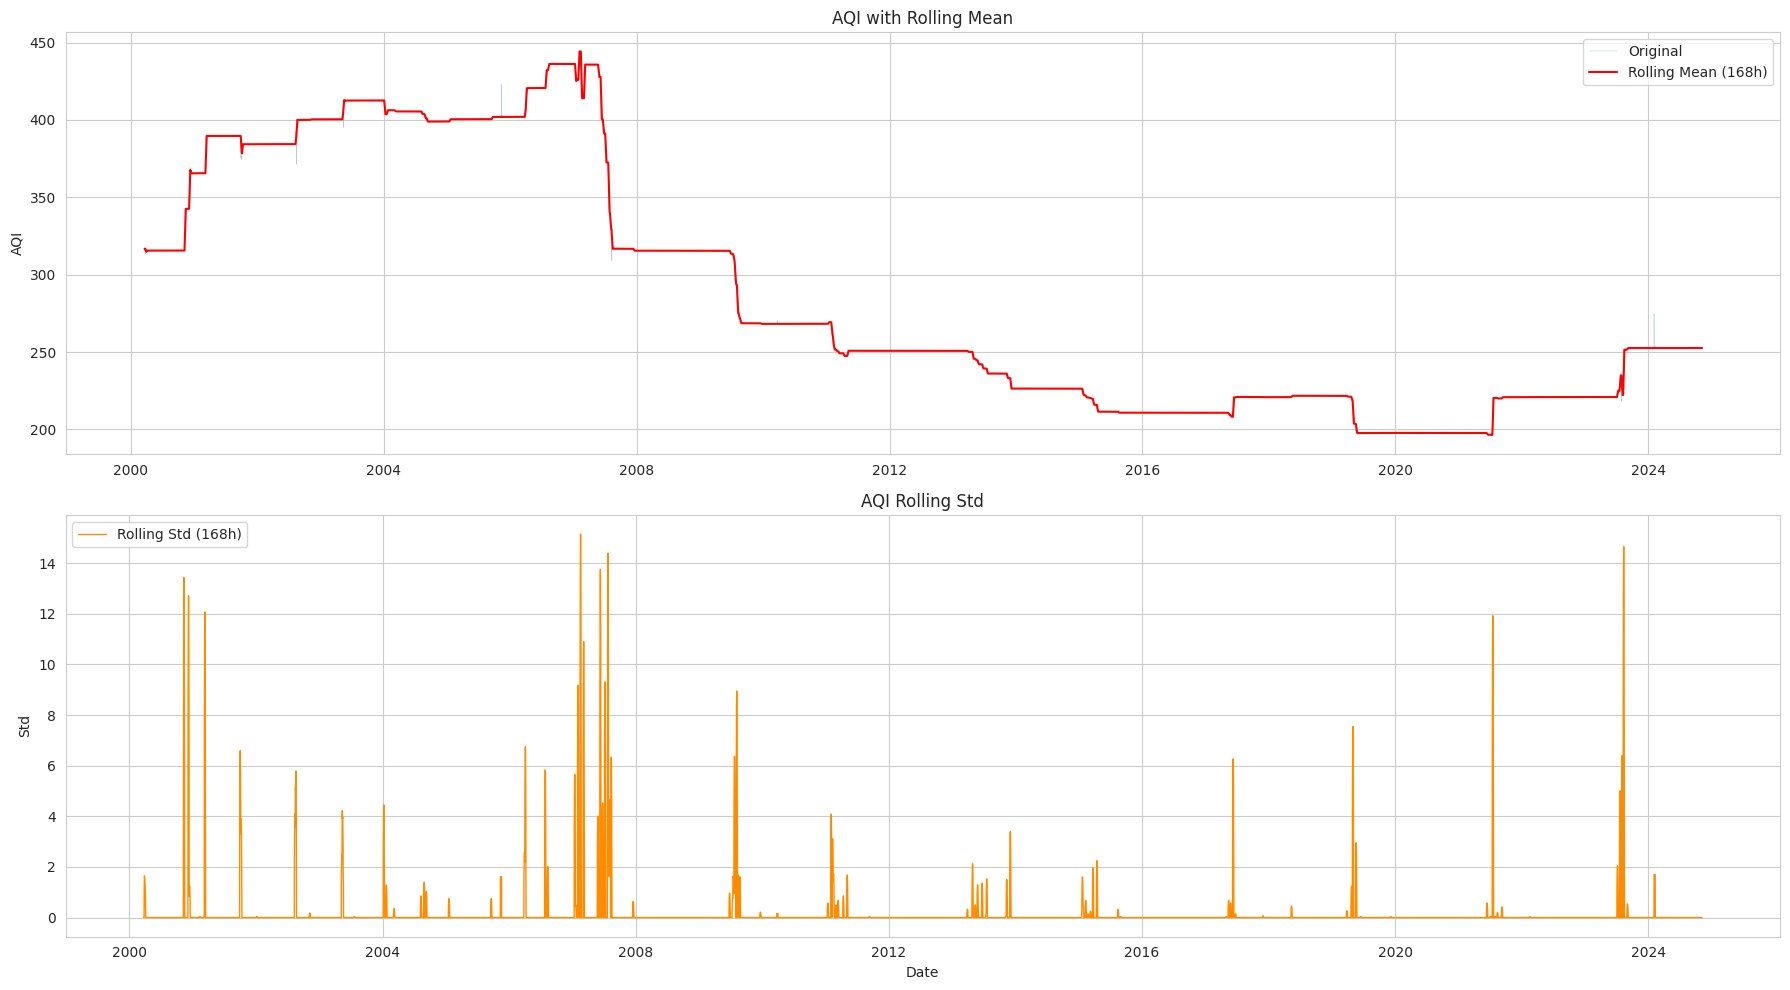

In [13]:
window = 24 * 7
rm = df[TARGET].rolling(window=window).mean()
rs = df[TARGET].rolling(window=window).std()
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
axes[0].plot(df['event_timestamp'], df[TARGET], lw=0.3, alpha=0.5, label='Original', color='steelblue')
axes[0].plot(df['event_timestamp'], rm, lw=1.5, label=f'Rolling Mean ({window}h)', color='red')
axes[0].set_title('AQI with Rolling Mean'); axes[0].set_ylabel('AQI'); axes[0].legend()
axes[1].plot(df['event_timestamp'], rs, lw=1.0, color='darkorange', label=f'Rolling Std ({window}h)')
axes[1].set_title('AQI Rolling Std'); axes[1].set_ylabel('Std'); axes[1].set_xlabel('Date'); axes[1].legend()
plt.tight_layout(); plt.show()

### 2.10 Temporal Trends

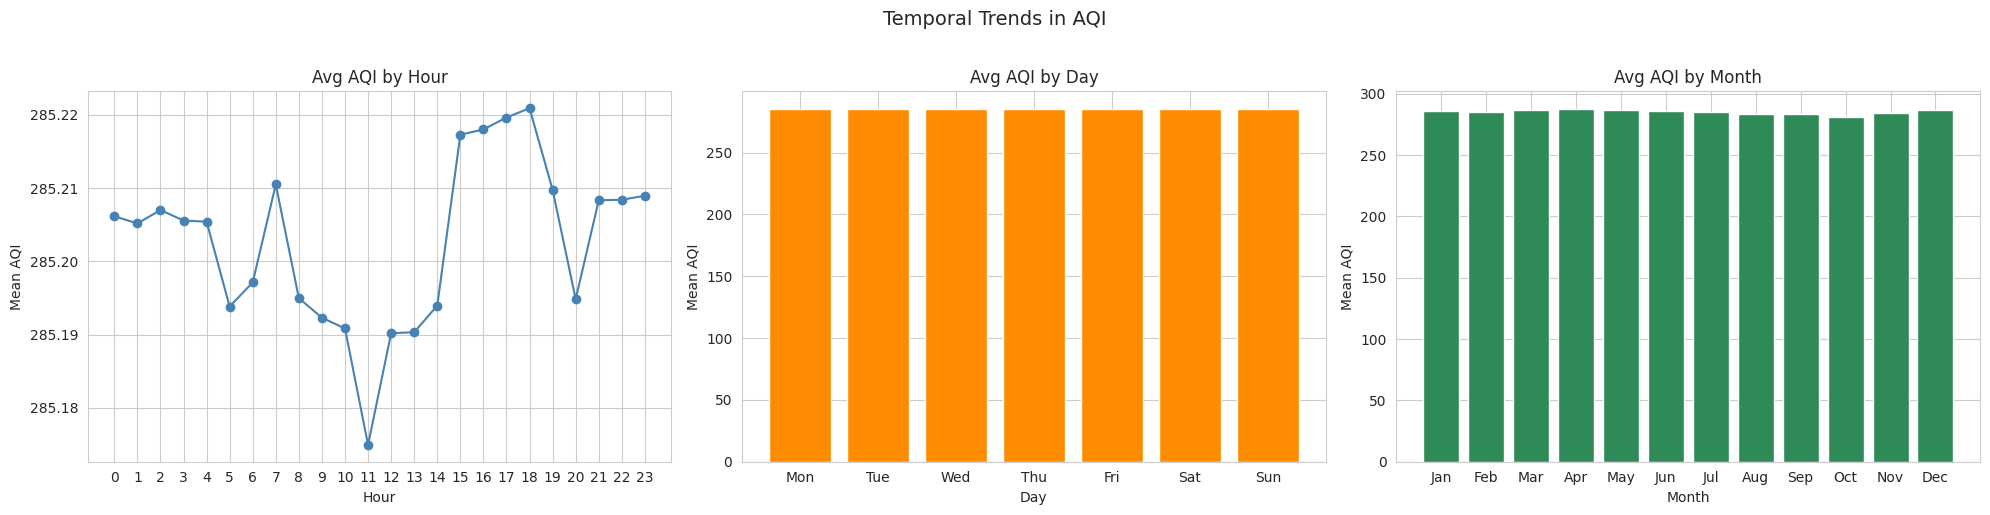

In [14]:
df['_h'] = df['event_timestamp'].dt.hour
df['_dow'] = df['event_timestamp'].dt.dayofweek
df['_m'] = df['event_timestamp'].dt.month
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
h = df.groupby('_h')[TARGET].mean()
axes[0].plot(h.index, h.values, marker='o', color='steelblue')
axes[0].set_title('Avg AQI by Hour'); axes[0].set_xlabel('Hour'); axes[0].set_ylabel('Mean AQI')
axes[0].set_xticks(range(0, 24))
dn = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
d = df.groupby('_dow')[TARGET].mean()
axes[1].bar(d.index, d.values, color='darkorange', tick_label=dn)
axes[1].set_title('Avg AQI by Day'); axes[1].set_xlabel('Day'); axes[1].set_ylabel('Mean AQI')
mn = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
m = df.groupby('_m')[TARGET].mean()
axes[2].bar(m.index, m.values, color='seagreen', tick_label=mn)
axes[2].set_title('Avg AQI by Month'); axes[2].set_xlabel('Month'); axes[2].set_ylabel('Mean AQI')
plt.suptitle('Temporal Trends in AQI', y=1.02, fontsize=14)
plt.tight_layout(); plt.show()
df.drop(columns=['_h', '_dow', '_m'], inplace=True)

## 3. Feature Engineering

In [15]:
num_missing_before = df.isnull().sum().sum()
df[feature_cols + [TARGET]] = df[feature_cols + [TARGET]].ffill().bfill()
num_missing_after = df.isnull().sum().sum()
print(f'Missing values: {num_missing_before} -> {num_missing_after}')

Missing values: 0 -> 0


In [16]:
# Temporal features
df['hour'] = df['event_timestamp'].dt.hour
df['day_of_week'] = df['event_timestamp'].dt.dayofweek
df['month'] = df['event_timestamp'].dt.month

# Lag features
df['aqi_lag_1'] = df[TARGET].shift(1)
df['aqi_lag_24'] = df[TARGET].shift(24)

# Rolling features (shifted to avoid leakage)
df['aqi_rolling_mean_24'] = df[TARGET].shift(1).rolling(window=24).mean()
df['aqi_rolling_std_24'] = df[TARGET].shift(1).rolling(window=24).std()

df = df.dropna().reset_index(drop=True)
print('Shape after feature engineering:', df.shape)
df.head()

Shape after feature engineering: (215490, 20)


,event_timestamp,temperature,humidity,pressure,wind_speed,wind_direction,pm25,pm10,no2,so2,o3,co,aqi,hour,day_of_week,month,aqi_lag_1,aqi_lag_24,aqi_rolling_mean_24,aqi_rolling_std_24
0,2000-03-16 13:00:00,27.207714,71.288429,984.611571,0.480786,205.0,246.714286,296.714286,46.864286,5.864286,7.5,23.307143,316.785714,13,3,3,316.785714,316.785714,316.785714,0.0
1,2000-03-16 14:00:00,27.207714,71.288429,984.611571,0.480786,205.0,246.714286,296.714286,46.864286,5.864286,7.5,23.307143,316.785714,14,3,3,316.785714,316.785714,316.785714,0.0
2,2000-03-16 15:00:00,27.207714,71.288429,984.611571,0.480786,205.0,246.714286,296.714286,46.864286,5.864286,7.5,23.307143,316.785714,15,3,3,316.785714,316.785714,316.785714,0.0
3,2000-03-16 16:00:00,27.207714,71.288429,984.611571,0.480786,205.0,246.714286,296.714286,46.864286,5.864286,7.5,23.307143,316.785714,16,3,3,316.785714,316.785714,316.785714,0.0
4,2000-03-16 17:00:00,27.207714,71.288429,984.611571,0.480786,205.0,246.714286,296.714286,46.864286,5.864286,7.5,23.307143,316.785714,17,3,3,316.785714,316.785714,316.785714,0.0


## 4. Train / Validation / Test Split (70 / 15 / 15)

In [17]:
ALL_FEATURES = feature_cols + ['hour', 'day_of_week', 'month',
                               'aqi_lag_1', 'aqi_lag_24',
                               'aqi_rolling_mean_24', 'aqi_rolling_std_24']
X = df[ALL_FEATURES].values
y = df[TARGET].values

n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print(f'Train: {X_train.shape[0]:,}  ({X_train.shape[0]/n*100:.1f}%)')
print(f'Val:   {X_val.shape[0]:,}  ({X_val.shape[0]/n*100:.1f}%)')
print(f'Test:  {X_test.shape[0]:,}  ({X_test.shape[0]/n*100:.1f}%)')
print(f'Features: {X_train.shape[1]}')

# Distribution diagnostics
print(f'\nTrain AQI  mean={y_train.mean():.2f}  std={y_train.std():.2f}  min={y_train.min():.2f}  max={y_train.max():.2f}')
print(f'Val AQI    mean={y_val.mean():.2f}  std={y_val.std():.2f}  min={y_val.min():.2f}  max={y_val.max():.2f}')
print(f'Test AQI   mean={y_test.mean():.2f}  std={y_test.std():.2f}  min={y_test.min():.2f}  max={y_test.max():.2f}')

Train: 150,843  (70.0%)
Val:   32,323  (15.0%)
Test:  32,324  (15.0%)
Features: 18

Train AQI  mean=313.35  std=77.51  min=208.21  max=444.20
Val AQI    mean=209.65  std=11.72  min=197.69  max=221.77
Test AQI   mean=229.40  std=18.01  min=196.54  max=274.64


## 5. Scaling

In [18]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_sc = scaler_X.fit_transform(X_train)
X_val_sc = scaler_X.transform(X_val)
X_test_sc = scaler_X.transform(X_test)

y_train_sc = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_sc = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_sc = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

os.makedirs('model', exist_ok=True)
joblib.dump({'scaler_X': scaler_X, 'scaler_y': scaler_y}, 'model/scaler.pkl')
print('Scalers saved.')

Scalers saved.


## 6. Sequence Creation

In [19]:
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i : i + seq_len])
        ys.append(y[i + seq_len])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 72

X_train_seq, y_train_seq = create_sequences(X_train_sc, y_train_sc, SEQ_LEN)
X_val_seq, y_val_seq = create_sequences(X_val_sc, y_val_sc, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(X_test_sc, y_test_sc, SEQ_LEN)

print(f'SEQ_LEN: {SEQ_LEN}')
print(f'Train: {X_train_seq.shape}')
print(f'Val:   {X_val_seq.shape}')
print(f'Test:  {X_test_seq.shape}')

SEQ_LEN: 72
Train: (150771, 72, 18)
Val:   (32251, 72, 18)
Test:  (32252, 72, 18)


## 7. GRU Model

3-layer stacked GRU (64→32→16) with L2 regularization, dropout, gradient clipping.
No BatchNorm (disrupts RNN temporal dynamics), no recurrent_dropout (preserves cuDNN speed).

In [20]:
L2_REG = 1e-3

def build_gru_model(seq_len, n_features, units_1=64, units_2=32, units_3=16,
                    dropout_rate=0.4, learning_rate=1e-3):
    init = initializers.GlorotUniform(seed=SEED)
    reg = regularizers.l2(L2_REG)

    model = keras.Sequential([
        layers.Input(shape=(seq_len, n_features)),
        layers.GRU(units_1, return_sequences=True, kernel_initializer=init,
                   kernel_regularizer=reg, recurrent_regularizer=reg),
        layers.Dropout(dropout_rate),
        layers.GRU(units_2, return_sequences=True, kernel_initializer=init,
                   kernel_regularizer=reg, recurrent_regularizer=reg),
        layers.Dropout(dropout_rate),
        layers.GRU(units_3, return_sequences=False, kernel_initializer=init,
                   kernel_regularizer=reg, recurrent_regularizer=reg),
        layers.Dropout(dropout_rate),
        layers.Dense(16, activation='relu', kernel_initializer=init, kernel_regularizer=reg),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
                  loss='mse', metrics=['mae'])
    return model

n_features = X_train_seq.shape[2]
tmp = build_gru_model(SEQ_LEN, n_features)
tmp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 72, 64)         │        16,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 72, 32)         │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 72, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,225 (110.25 KB)

 Trainable params: 28,225 (110.25 KB)

 Non-trainable params: 0 (0.00 B)

### 7.1 GRU Hyperparameter Search

In [21]:
HP_GRID = {
    'units_1': [32, 64],
    'units_2': [16, 32],
    'units_3': [8, 16],
    'dropout_rate': [0.4, 0.5],
    'learning_rate': [1e-3, 5e-4],
    'batch_size': [128, 256],
}

NUM_RANDOM_TRIALS = 6
SEARCH_EPOCHS = 30

def sample_hp(grid, seed_offset=0):
    rng = np.random.RandomState(SEED + seed_offset)
    return {k: rng.choice(v) for k, v in grid.items()}

gru_search_results = []
for trial in range(NUM_RANDOM_TRIALS):
    hp = sample_hp(HP_GRID, seed_offset=trial)
    print(f'\n--- GRU Trial {trial+1}/{NUM_RANDOM_TRIALS} ---')
    print(hp)
    model = build_gru_model(SEQ_LEN, n_features,
        units_1=int(hp['units_1']), units_2=int(hp['units_2']), units_3=int(hp['units_3']),
        dropout_rate=float(hp['dropout_rate']), learning_rate=float(hp['learning_rate']))
    es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    hist = model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                     epochs=SEARCH_EPOCHS, batch_size=int(hp['batch_size']), callbacks=[es], verbose=0)
    bvl = min(hist.history['val_loss'])
    print(f'Best val_loss: {bvl:.6f}')
    gru_search_results.append((hp, bvl))

gru_search_results.sort(key=lambda x: x[1])
best_gru_hp = gru_search_results[0][0]
print('\nBest GRU HP:', best_gru_hp)
print('Best val_loss:', gru_search_results[0][1])


--- GRU Trial 1/6 ---
{'units_1': np.int64(32), 'units_2': np.int64(32), 'units_3': np.int64(8), 'dropout_rate': np.float64(0.4), 'learning_rate': np.float64(0.001), 'batch_size': np.int64(256)}
Best val_loss: 0.016295

--- GRU Trial 2/6 ---
{'units_1': np.int64(32), 'units_2': np.int64(16), 'units_3': np.int64(16), 'dropout_rate': np.float64(0.5), 'learning_rate': np.float64(0.0005), 'batch_size': np.int64(128)}
Best val_loss: 0.007400

--- GRU Trial 3/6 ---
{'units_1': np.int64(32), 'units_2': np.int64(32), 'units_3': np.int64(16), 'dropout_rate': np.float64(0.5), 'learning_rate': np.float64(0.0005), 'batch_size': np.int64(256)}
Best val_loss: 0.011990

--- GRU Trial 4/6 ---
{'units_1': np.int64(64), 'units_2': np.int64(16), 'units_3': np.int64(16), 'dropout_rate': np.float64(0.4), 'learning_rate': np.float64(0.001), 'batch_size': np.int64(256)}
Best val_loss: 0.007270

--- GRU Trial 5/6 ---
{'units_1': np.int64(64), 'units_2': np.int64(32), 'units_3': np.int64(8), 'dropout_rate': n

### 7.2 Train Final GRU

In [22]:
FINAL_EPOCHS = 100

gru_model = build_gru_model(SEQ_LEN, n_features,
    units_1=int(best_gru_hp['units_1']), units_2=int(best_gru_hp['units_2']),
    units_3=int(best_gru_hp['units_3']),
    dropout_rate=float(best_gru_hp['dropout_rate']),
    learning_rate=float(best_gru_hp['learning_rate']))

gru_cbs = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

t0 = time.time()
gru_history = gru_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
    epochs=FINAL_EPOCHS, batch_size=int(best_gru_hp['batch_size']), callbacks=gru_cbs, verbose=1)
gru_train_time = time.time() - t0
print(f'\nGRU training time: {gru_train_time:.1f}s')

Epoch 1/100
589/589 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.1486 - mae: 0.1213 - val_loss: 0.0161 - val_mae: 0.0156 - learning_rate: 0.0010
Epoch 2/100
589/589 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0167 - mae: 0.0451 - val_loss: 0.0076 - val_mae: 0.0302 - learning_rate: 0.0010
Epoch 3/100
589/589 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0090 - mae: 0.0376 - val_loss: 0.0053 - val_mae: 0.0267 - learning_rate: 0.0010
Epoch 4/100
589/589 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0069 - mae: 0.0337 - val_loss: 0.0045 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 5/100
589/589 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0059 - mae: 0.0312 - val_loss: 0.0043 - val_mae: 0.0284 - learning_rate: 0.0010
Epoch 6/100
589/589 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0054 - mae: 0.0292 - val_loss: 0.0042 - val_mae: 0.0276 - learning_rate: 0.0010
Epoch 7/100
589/589 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0050 - mae: 0.0279 - val_loss: 0.0044 - val_mae: 0.0327 - learning

## 8. LSTM Model

Same regularization strategy as GRU.

In [23]:
def build_lstm_model(seq_len, n_features, units_1=64, units_2=32, units_3=16,
                     dropout_rate=0.4, learning_rate=1e-3):
    init = initializers.GlorotUniform(seed=SEED)
    reg = regularizers.l2(L2_REG)

    model = keras.Sequential([
        layers.Input(shape=(seq_len, n_features)),
        layers.LSTM(units_1, return_sequences=True, kernel_initializer=init,
                    kernel_regularizer=reg, recurrent_regularizer=reg),
        layers.Dropout(dropout_rate),
        layers.LSTM(units_2, return_sequences=True, kernel_initializer=init,
                    kernel_regularizer=reg, recurrent_regularizer=reg),
        layers.Dropout(dropout_rate),
        layers.LSTM(units_3, return_sequences=False, kernel_initializer=init,
                    kernel_regularizer=reg, recurrent_regularizer=reg),
        layers.Dropout(dropout_rate),
        layers.Dense(16, activation='relu', kernel_initializer=init, kernel_regularizer=reg),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
                  loss='mse', metrics=['mae'])
    return model

tmp = build_lstm_model(SEQ_LEN, n_features)
tmp.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 72, 64)         │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 72, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 72, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,089 (144.88 KB)

 Trainable params: 37,089 (144.88 KB)

 Non-trainable params: 0 (0.00 B)

### 8.1 LSTM Hyperparameter Search

In [25]:
lstm_search_results = []
for trial in range(NUM_RANDOM_TRIALS):
    hp = sample_hp(HP_GRID, seed_offset=trial + 100)
    print(f'\n--- LSTM Trial {trial+1}/{NUM_RANDOM_TRIALS} ---')
    print(hp)
    model = build_lstm_model(SEQ_LEN, n_features,
        units_1=int(hp['units_1']), units_2=int(hp['units_2']), units_3=int(hp['units_3']),
        dropout_rate=float(hp['dropout_rate']), learning_rate=float(hp['learning_rate']))
    es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    hist = model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                     epochs=SEARCH_EPOCHS, batch_size=int(hp['batch_size']), callbacks=[es], verbose=0)
    bvl = min(hist.history['val_loss'])
    print(f'Best val_loss: {bvl:.6f}')
    lstm_search_results.append((hp, bvl))

lstm_search_results.sort(key=lambda x: x[1])
best_lstm_hp = lstm_search_results[0][0]
print('\nBest LSTM HP:', best_lstm_hp)
print('Best val_loss:', lstm_search_results[0][1])


--- LSTM Trial 1/6 ---
{'units_1': np.int64(64), 'units_2': np.int64(32), 'units_3': np.int64(16), 'dropout_rate': np.float64(0.5), 'learning_rate': np.float64(0.001), 'batch_size': np.int64(128)}
Best val_loss: 0.007244

--- LSTM Trial 2/6 ---
{'units_1': np.int64(32), 'units_2': np.int64(32), 'units_3': np.int64(16), 'dropout_rate': np.float64(0.5), 'learning_rate': np.float64(0.001), 'batch_size': np.int64(128)}
Best val_loss: 0.004512

--- LSTM Trial 3/6 ---
{'units_1': np.int64(64), 'units_2': np.int64(16), 'units_3': np.int64(8), 'dropout_rate': np.float64(0.4), 'learning_rate': np.float64(0.001), 'batch_size': np.int64(128)}
Best val_loss: 0.011126

--- LSTM Trial 4/6 ---
{'units_1': np.int64(64), 'units_2': np.int64(32), 'units_3': np.int64(8), 'dropout_rate': np.float64(0.5), 'learning_rate': np.float64(0.001), 'batch_size': np.int64(256)}
Best val_loss: 0.006325

--- LSTM Trial 5/6 ---
{'units_1': np.int64(64), 'units_2': np.int64(16), 'units_3': np.int64(16), 'dropout_rate'

### 8.2 Train Final LSTM

In [26]:
lstm_model = build_lstm_model(SEQ_LEN, n_features,
    units_1=int(best_lstm_hp['units_1']), units_2=int(best_lstm_hp['units_2']),
    units_3=int(best_lstm_hp['units_3']),
    dropout_rate=float(best_lstm_hp['dropout_rate']),
    learning_rate=float(best_lstm_hp['learning_rate']))

lstm_cbs = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

t0 = time.time()
lstm_history = lstm_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
    epochs=FINAL_EPOCHS, batch_size=int(best_lstm_hp['batch_size']), callbacks=lstm_cbs, verbose=1)
lstm_train_time = time.time() - t0
print(f'\nLSTM training time: {lstm_train_time:.1f}s')

Epoch 1/100
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0943 - mae: 0.0778 - val_loss: 0.0081 - val_mae: 0.0501 - learning_rate: 0.0010
Epoch 2/100
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0060 - mae: 0.0321 - val_loss: 0.0054 - val_mae: 0.0495 - learning_rate: 0.0010
Epoch 3/100
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0038 - mae: 0.0278 - val_loss: 0.0045 - val_mae: 0.0474 - learning_rate: 0.0010
Epoch 4/100
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 0.0030 - mae: 0.0259 - val_loss: 0.0041 - val_mae: 0.0469 - learning_rate: 0.0010
Epoch 5/100
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0026 - mae: 0.0248 - val_loss: 0.0037 - val_mae: 0.0476 - learning_rate: 0.0010
Epoch 6/100
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 0.0023 - mae: 0.0238 - val_loss: 0.0040 - val_mae: 0.0474 - learning_rate: 0.0010
Epoch 7/100
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0021 - mae: 0.0236 - val_loss: 0.0033 - val_mae: 0.

## 9. Evaluation & Comparison

In [27]:
def evaluate_model(model, X_test, y_test_sc, scaler_y, name):
    y_pred_sc = model.predict(X_test, verbose=0).flatten()
    y_true = scaler_y.inverse_transform(y_test_sc.reshape(-1, 1)).flatten()
    y_pred = scaler_y.inverse_transform(y_pred_sc.reshape(-1, 1)).flatten()
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f'\n--- {name} Test Metrics ---')
    print(f'MSE:  {mse:.4f}\nMAE:  {mae:.4f}\nRMSE: {rmse:.4f}\nR2:   {r2:.4f}')
    return {'name': name, 'mse': mse, 'mae': mae, 'rmse': rmse, 'r2': r2,
            'y_true': y_true, 'y_pred': y_pred}

gru_res = evaluate_model(gru_model, X_test_seq, y_test_seq, scaler_y, 'GRU')
lstm_res = evaluate_model(lstm_model, X_test_seq, y_test_seq, scaler_y, 'LSTM')


--- GRU Test Metrics ---
MSE:  218.0214
MAE:  13.5396
RMSE: 14.7655
R2:   0.3244

--- LSTM Test Metrics ---
MSE:  553.2680
MAE:  18.9766
RMSE: 23.5217
R2:   -0.7143


### 9.1 Loss Curves

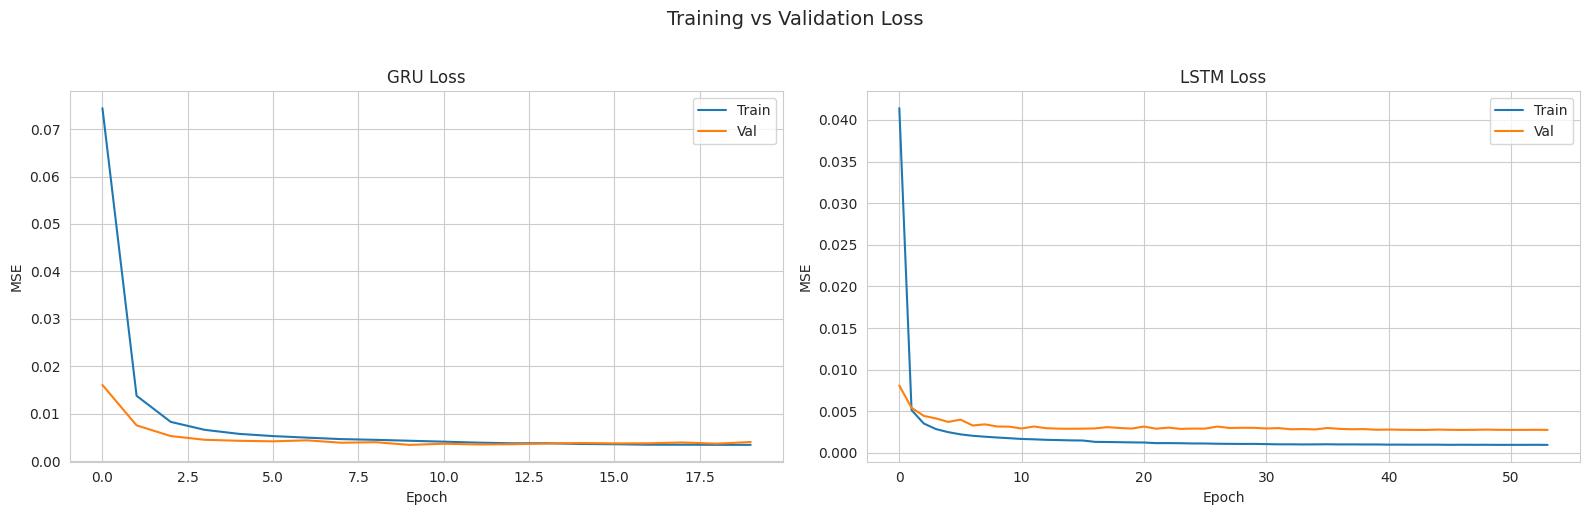

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].plot(gru_history.history['loss'], label='Train'); axes[0].plot(gru_history.history['val_loss'], label='Val')
axes[0].set_title('GRU Loss'); axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('MSE'); axes[0].legend()
axes[1].plot(lstm_history.history['loss'], label='Train'); axes[1].plot(lstm_history.history['val_loss'], label='Val')
axes[1].set_title('LSTM Loss'); axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('MSE'); axes[1].legend()
plt.suptitle('Training vs Validation Loss', y=1.02, fontsize=14)
plt.tight_layout(); plt.show()

### 9.2 Actual vs Predicted

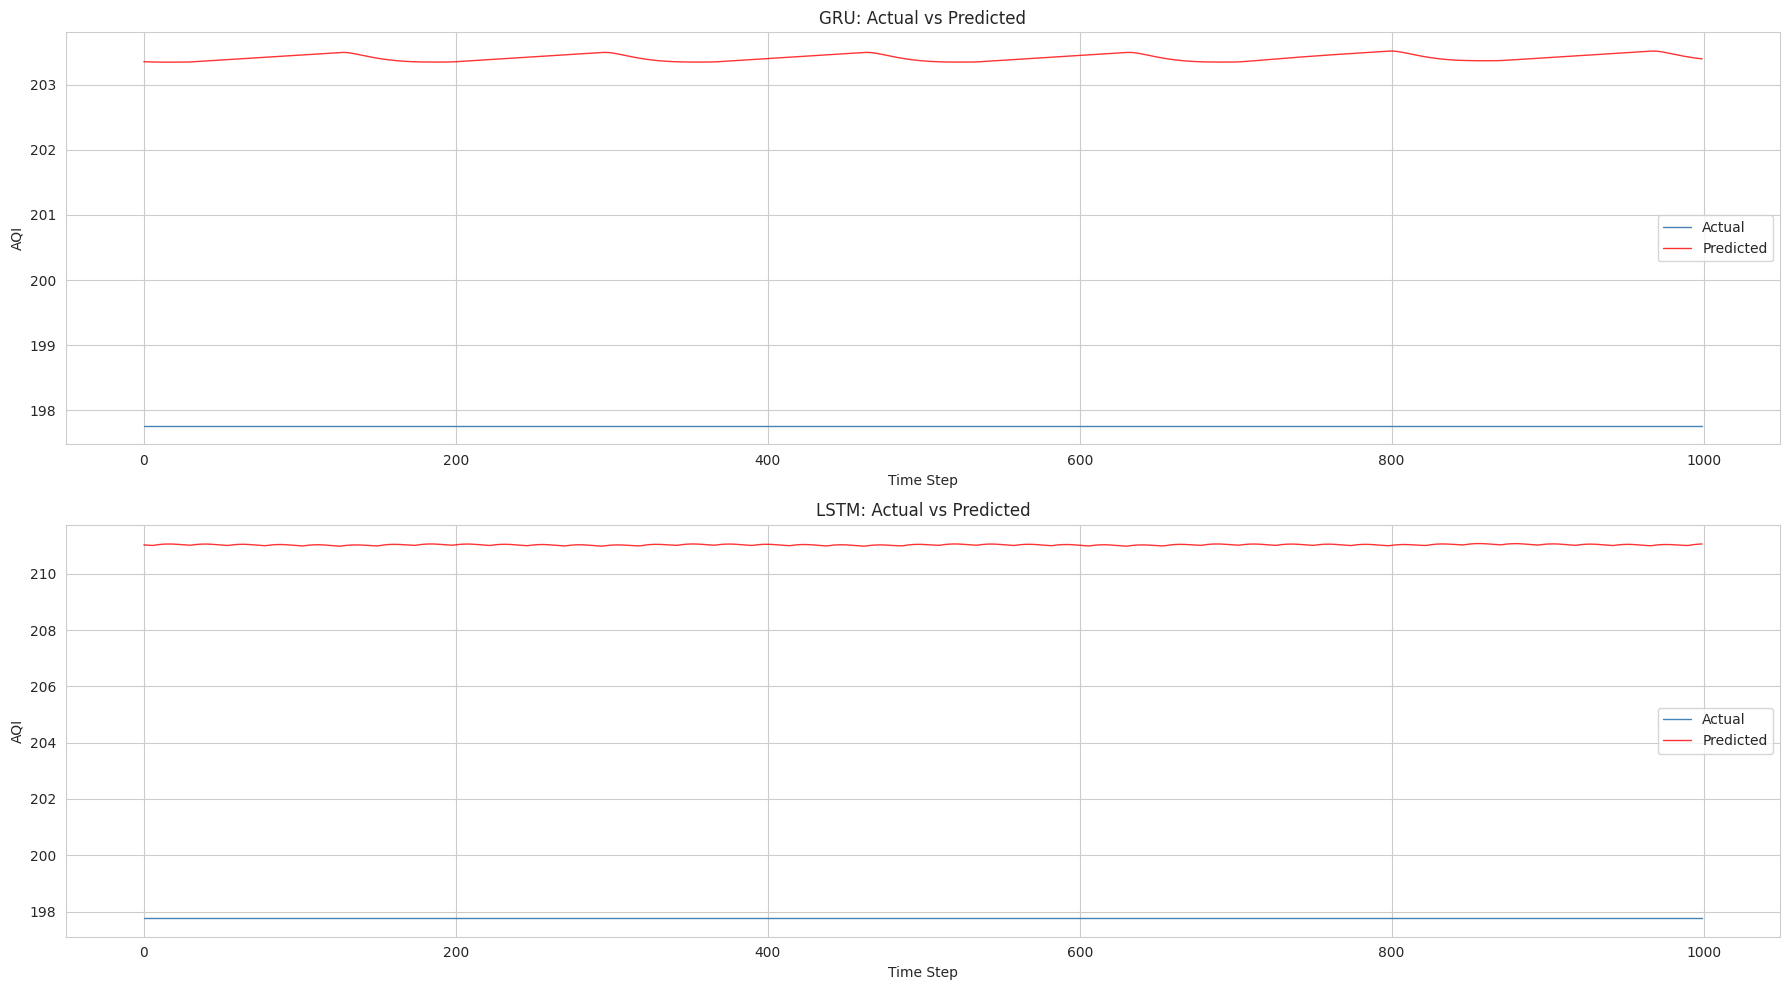

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
pl = min(1000, len(gru_res['y_true']))
axes[0].plot(range(pl), gru_res['y_true'][:pl], label='Actual', lw=1.0, color='steelblue')
axes[0].plot(range(pl), gru_res['y_pred'][:pl], label='Predicted', lw=1.0, color='red', alpha=0.8)
axes[0].set_title('GRU: Actual vs Predicted'); axes[0].set_xlabel('Time Step'); axes[0].set_ylabel('AQI'); axes[0].legend()
axes[1].plot(range(pl), lstm_res['y_true'][:pl], label='Actual', lw=1.0, color='steelblue')
axes[1].plot(range(pl), lstm_res['y_pred'][:pl], label='Predicted', lw=1.0, color='red', alpha=0.8)
axes[1].set_title('LSTM: Actual vs Predicted'); axes[1].set_xlabel('Time Step'); axes[1].set_ylabel('AQI'); axes[1].legend()
plt.tight_layout(); plt.show()

### 9.3 Residual Plots

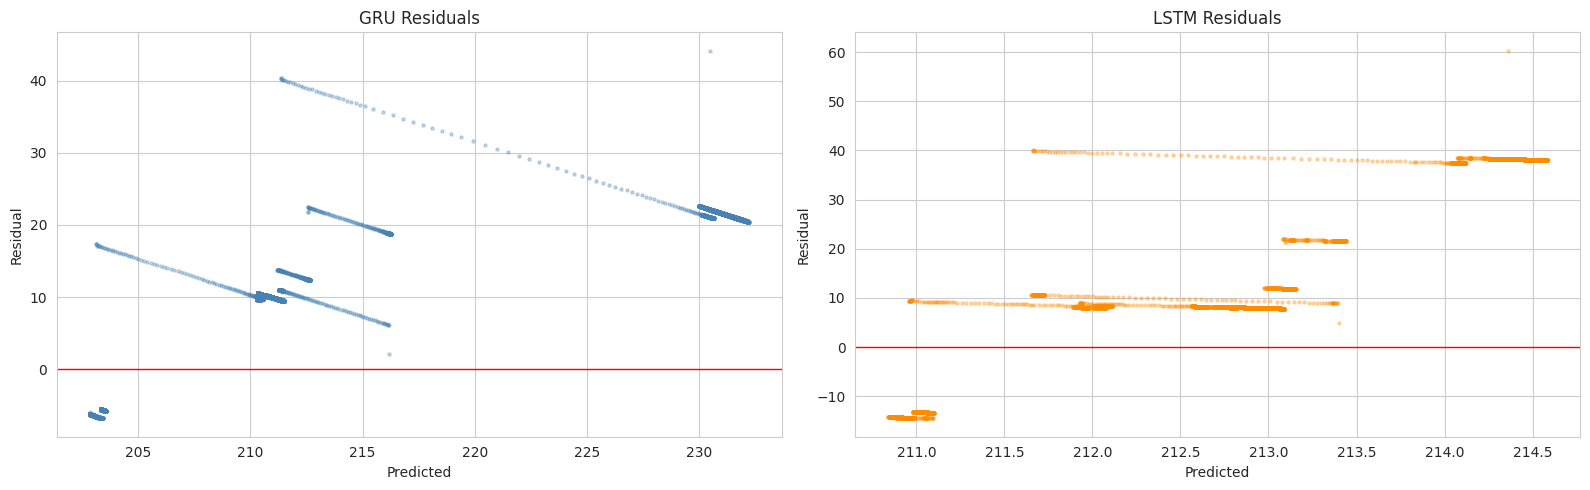

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].scatter(gru_res['y_pred'], gru_res['y_true']-gru_res['y_pred'], alpha=0.3, s=5, color='steelblue')
axes[0].axhline(y=0, color='red', lw=1); axes[0].set_title('GRU Residuals'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Residual')
axes[1].scatter(lstm_res['y_pred'], lstm_res['y_true']-lstm_res['y_pred'], alpha=0.3, s=5, color='darkorange')
axes[1].axhline(y=0, color='red', lw=1); axes[1].set_title('LSTM Residuals'); axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Residual')
plt.tight_layout(); plt.show()

### 9.4 Comparison Table

In [31]:
comp = pd.DataFrame({
    'Model': ['GRU', 'LSTM'],
    'MSE': [gru_res['mse'], lstm_res['mse']],
    'MAE': [gru_res['mae'], lstm_res['mae']],
    'RMSE': [gru_res['rmse'], lstm_res['rmse']],
    'R2': [gru_res['r2'], lstm_res['r2']],
    'Train Time (s)': [round(gru_train_time, 1), round(lstm_train_time, 1)],
    'Best Val Loss': [min(gru_history.history['val_loss']), min(lstm_history.history['val_loss'])]
})
print(comp.to_string(index=False))

Model        MSE       MAE      RMSE        R2  Train Time (s)  Best Val Loss
  GRU 218.021381 13.539607 14.765547  0.324444           197.7       0.003468
 LSTM 553.268035 18.976637 23.521650 -0.714343          1029.6       0.002763


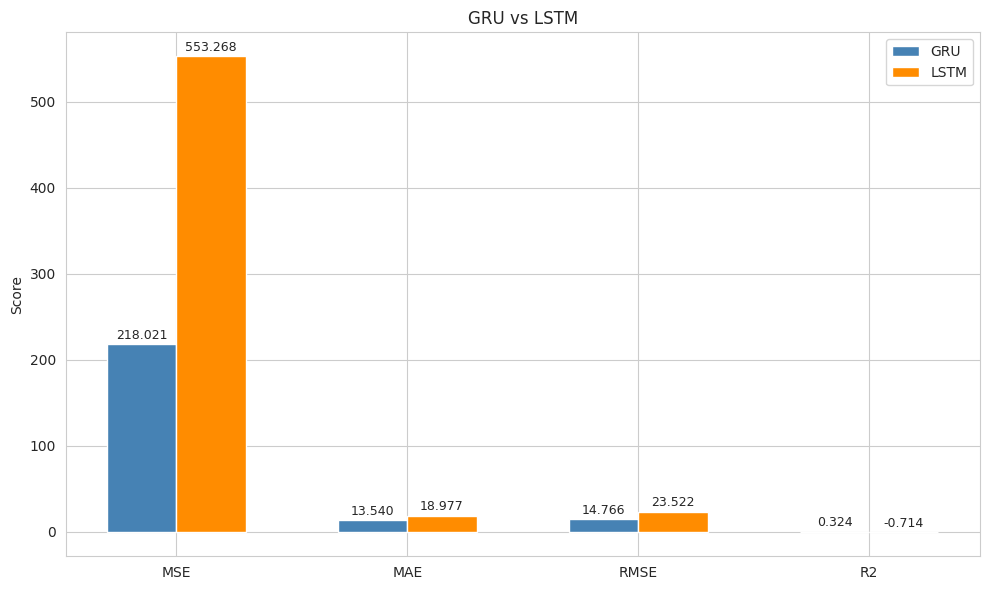

In [32]:
metrics = ['MSE', 'MAE', 'RMSE', 'R2']
gv = [gru_res['mse'], gru_res['mae'], gru_res['rmse'], gru_res['r2']]
lv = [lstm_res['mse'], lstm_res['mae'], lstm_res['rmse'], lstm_res['r2']]
x = np.arange(len(metrics)); w = 0.3
fig, ax = plt.subplots(figsize=(10, 6))
b1 = ax.bar(x - w/2, gv, w, label='GRU', color='steelblue')
b2 = ax.bar(x + w/2, lv, w, label='LSTM', color='darkorange')
ax.set_title('GRU vs LSTM'); ax.set_ylabel('Score'); ax.set_xticks(x); ax.set_xticklabels(metrics); ax.legend()
for b in b1:
    ax.annotate(f'{b.get_height():.3f}', xy=(b.get_x()+b.get_width()/2, b.get_height()),
                xytext=(0,4), textcoords='offset points', ha='center', fontsize=9)
for b in b2:
    ax.annotate(f'{b.get_height():.3f}', xy=(b.get_x()+b.get_width()/2, b.get_height()),
                xytext=(0,4), textcoords='offset points', ha='center', fontsize=9)
plt.tight_layout(); plt.show()

## 10. Save & Download

In [33]:
gru_model.save('model/gru_model.keras')
lstm_model.save('model/lstm_model.keras')
print('Models saved.')

metadata = {
    'seq_len': SEQ_LEN, 'features': ALL_FEATURES, 'target': TARGET,
    'best_gru_hp': {k: float(v) if isinstance(v, (np.floating, float)) else int(v) for k, v in best_gru_hp.items()},
    'best_lstm_hp': {k: float(v) if isinstance(v, (np.floating, float)) else int(v) for k, v in best_lstm_hp.items()},
}
joblib.dump(metadata, 'model/metadata.pkl')
print('Metadata saved.')

Models saved.
Metadata saved.


In [34]:
from google.colab import files
files.download('model/gru_model.keras')
files.download('model/lstm_model.keras')
files.download('model/scaler.pkl')
files.download('model/metadata.pkl')
print('All files downloaded.')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All files downloaded.


---
**End of notebook.** Use the saved models with `app.py` for real-time AQI prediction.